In [1]:
import os
from functools import partial
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pyro
import pyro.distributions as dist
from torch import nn
from pyro.nn import PyroModule


In [13]:
exo_dist = {
    'Nr': dist.Bernoulli(torch.tensor(0.7)),
    'Ns': dist.Bernoulli(torch.tensor(0.35)),
    'Na': dist.Normal(torch.tensor(0.), torch.tensor(1.))
}

In [14]:
def model():
    exo_dist = {
        'Nr': dist.Bernoulli(torch.tensor(0.7)),
        'Ns': dist.Bernoulli(torch.tensor(0.35)),
        'Na': dist.Normal(torch.tensor(0.), torch.tensor(1.))
    }
    # sample from bernoulli 0 or 1, 0 at 70% freq (made up)
    R = pyro.sample("R", exo_dist['Nr'])
    S = pyro.sample("S", exo_dist['Ns'])
    
    # random gaussian dist for ability 
    A = pyro.sample("A", exo_dist['Na'])
    
    
    G = pyro.sample("G", dist.Normal(A + 2.1 * R + 3.3 * S, 0.5))
    
    L = pyro.sample("L", dist.Normal(A + 5.8*R + 0.7*S, 0.1))
    
    F = pyro.sample("F", dist.Normal(A + 2.3*R + 1.*S, 0.3))

trace_handler = pyro.poutine.trace(model)
samples = pd.DataFrame(columns=['R', 'S', 'A', 'G', 'L', 'F', 'p'])

## Unaware Model

This model uses only G and L to predict FYA. It is indirectly biased because R/S affect G and L, and also affect F.

In [15]:
unaware_sample= []
for i in range(1000):
    trace = trace_handler.get_trace()
    R = trace.nodes['R']['value']
    S = trace.nodes['S']['value']
    A = trace.nodes['A']['value']
    G = trace.nodes['G']['value']
    L = trace.nodes['L']['value']
    F = trace.nodes['F']['value']
    # get prob of each combination
    log_prob = trace.log_prob_sum()
    p = np.exp(log_prob)
    samples = samples.append({'R': R, 'S': S, 'A': A, 'G': G, 'L':L, 'F': F, 'p': p}, ignore_index=True)
    unaware_sample.append(([G,L,F]))

samples.head()

,R,S,A,G,L,F,p
0,tensor(1.),tensor(0.),tensor(0.0263),tensor(1.4554),tensor(5.6359),tensor(2.4945),tensor(0.0435)
1,tensor(1.),tensor(0.),tensor(0.7094),tensor(3.0938),tensor(6.4882),tensor(2.9650),tensor(0.4915)
2,tensor(0.),tensor(0.),tensor(1.6020),tensor(1.7183),tensor(1.5369),tensor(1.3702),tensor(0.0533)
3,tensor(1.),tensor(1.),tensor(2.2869),tensor(8.0049),tensor(8.8084),tensor(5.8834),tensor(0.0148)
4,tensor(0.),tensor(0.),tensor(1.0806),tensor(0.4785),tensor(1.0816),tensor(1.2844),tensor(0.0706)


In [17]:
# for CI testing
smoke_test = ('CI' in os.environ)
pyro.enable_validation(True)
pyro.set_rng_seed(1)
pyro.enable_validation(True)


# setup
assert issubclass(PyroModule[nn.Linear], nn.Linear)
assert issubclass(PyroModule[nn.Linear], PyroModule)


#Data to regress
unaware_sample = torch.tensor(unaware_sample)
x_data, y_data = unaware_sample[:, :-1], unaware_sample[:, -1]

# Regression model
# 2 = in features, 1=out feature
linear_reg_model = PyroModule[nn.Linear](2, 1)

# Define loss and optimize
loss_fn = torch.nn.MSELoss(reduction='sum')
optim = torch.optim.Adam(linear_reg_model.parameters(), lr=0.05)
num_iterations = 500 if not smoke_test else 2

def train():
    # run the model forward on the data
    y_pred = linear_reg_model(x_data).squeeze(-1)
    # calculate the mse loss
    loss = loss_fn(y_pred, y_data)
    # initialize gradients to zero
    optim.zero_grad()
    # backpropagate
    loss.backward()
    # take a gradient step
    optim.step()
    return loss

for j in range(num_iterations):
    loss = train()
    if (j + 1) % 10 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss.item()))

# Inspect learned parameters
print("Learned parameters:")
for name, param in linear_reg_model.named_parameters():
    print(name, param.data.numpy())

[iteration 0010] loss: 1228.0948
[iteration 0020] loss: 920.1564
[iteration 0030] loss: 762.8047
[iteration 0040] loss: 438.1056
[iteration 0050] loss: 353.0892
[iteration 0060] loss: 321.7837
[iteration 0070] loss: 300.1779
[iteration 0080] loss: 289.3389
[iteration 0090] loss: 284.8181
[iteration 0100] loss: 282.8357
[iteration 0110] loss: 281.8677
[iteration 0120] loss: 281.3944
[iteration 0130] loss: 281.1844
[iteration 0140] loss: 281.1036
[iteration 0150] loss: 281.0769
[iteration 0160] loss: 281.0694
[iteration 0170] loss: 281.0674
[iteration 0180] loss: 281.0671
[iteration 0190] loss: 281.0671
[iteration 0200] loss: 281.0671
[iteration 0210] loss: 281.0671
[iteration 0220] loss: 281.0671
[iteration 0230] loss: 281.0671
[iteration 0240] loss: 281.0671
[iteration 0250] loss: 281.0671
[iteration 0260] loss: 281.0671
[iteration 0270] loss: 281.0671
[iteration 0280] loss: 281.0671
[iteration 0290] loss: 281.0671
[iteration 0300] loss: 281.0671
[iteration 0310] loss: 281.0671
[iterat

(array([ 17.,  45.,  56.,  47.,  38.,  81., 155., 137.,  40.,  14.]),
 array([-1.743669  , -1.1420765 , -0.5404841 ,  0.06110845,  0.66270095,
         1.2642934 ,  1.865886  ,  2.4674785 ,  3.0690708 ,  3.6706634 ,
         4.272256  ], dtype=float32),
 <a list of 10 Patch objects>)

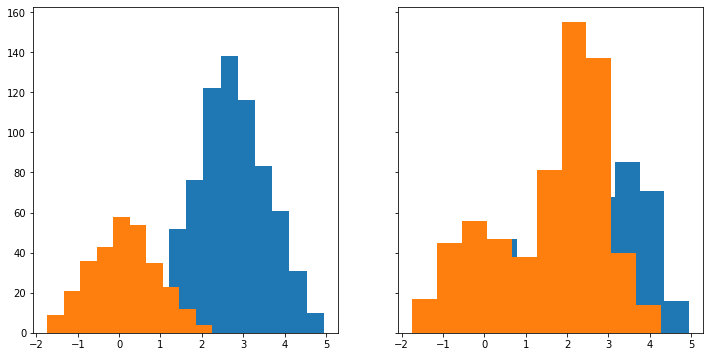

In [18]:
fit = samples.copy()
fit["mean"] = linear_reg_model(x_data).detach().numpy()

S1 = fit[fit["S"] == 1]
S0 = fit[fit["S"] == 0]
R1 = fit[fit["R"] == 1]
R0 = fit[fit["R"] == 0]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
ax[0].hist(R1["mean"])
ax[0].hist(R0["mean"])
ax[1].hist(S1["mean"])
ax[1].hist(S0["mean"])


## Full Model

This model uses all observable variables. This has the consequence of using R/S directly in its decision. 
(Causal model here would show R/S causing FYA as well). 

In [33]:
samples = pd.DataFrame(columns=['R', 'S', 'A', 'G', 'L', 'F', 'p'])
full_sample= []
for i in range(1000):
    trace = trace_handler.get_trace(exo_dist)
    R = trace.nodes['R']['value']
    S = trace.nodes['S']['value']
    A = trace.nodes['A']['value']
    G = trace.nodes['G']['value']
    L = trace.nodes['L']['value']
    F = trace.nodes['F']['value']
    # get prob of each combination
    log_prob = trace.log_prob_sum()
    p = np.exp(log_prob)
    samples=samples.append({'R': R, 'S': S, 'A': A, 'G': G, 'L':L, 'F': F, 'p': p}, ignore_index=True)
    full_sample.append(([R,S,G,L,F]))

samples.head()

,R,S,A,G,L,F,p
0,tensor(1.),tensor(1.),tensor(0.0739),tensor(4.8844),tensor(6.4200),tensor(3.2143),tensor(0.0547)
1,tensor(1.),tensor(0.),tensor(1.6005),tensor(3.9457),tensor(7.4651),tensor(4.0628),tensor(0.1327)
2,tensor(1.),tensor(0.),tensor(-0.6672),tensor(1.1866),tensor(5.1768),tensor(1.9296),tensor(0.3032)
3,tensor(1.),tensor(0.),tensor(-0.2638),tensor(2.5346),tensor(5.3216),tensor(1.7472),tensor(0.0176)
4,tensor(1.),tensor(0.),tensor(-0.9319),tensor(1.6503),tensor(4.8414),tensor(0.9323),tensor(0.1051)


In [34]:
#Data to regress
full_sample = torch.tensor(full_sample)
x_data, y_data = full_sample[:, :-1], full_sample[:, -1]

# Regression model
# 2 = in features, 1=out feature
linear_reg_model = PyroModule[nn.Linear](4, 1)

# Define loss and optimize
loss_fn = torch.nn.MSELoss(reduction='sum')
optim = torch.optim.Adam(linear_reg_model.parameters(), lr=0.05)
num_iterations = 500 if not smoke_test else 2

def train():
    # run the model forward on the data
    y_pred = linear_reg_model(x_data).squeeze(-1)
    # calculate the mse loss
    loss = loss_fn(y_pred, y_data)
    # initialize gradients to zero
    optim.zero_grad()
    # backpropagate
    loss.backward()
    # take a gradient step
    optim.step()
    return loss

for j in range(num_iterations):
    loss = train()
    if (j + 1) % 10 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss.item()))

# Inspect learned parameters
print("Learned parameters:")
for name, param in linear_reg_model.named_parameters():
    print(name, param.data.numpy())
    

[iteration 0010] loss: 789.6496
[iteration 0020] loss: 971.4789
[iteration 0030] loss: 723.6378
[iteration 0040] loss: 383.9923
[iteration 0050] loss: 370.0474
[iteration 0060] loss: 339.2785
[iteration 0070] loss: 302.6099
[iteration 0080] loss: 278.8698
[iteration 0090] loss: 261.9639
[iteration 0100] loss: 248.0414
[iteration 0110] loss: 236.1470
[iteration 0120] loss: 225.9137
[iteration 0130] loss: 217.0389
[iteration 0140] loss: 209.2750
[iteration 0150] loss: 202.4385
[iteration 0160] loss: 196.3949
[iteration 0170] loss: 191.0415
[iteration 0180] loss: 186.2945
[iteration 0190] loss: 182.0818
[iteration 0200] loss: 178.3382
[iteration 0210] loss: 175.0039
[iteration 0220] loss: 172.0241
[iteration 0230] loss: 169.3489
[iteration 0240] loss: 166.9330
[iteration 0250] loss: 164.7365
[iteration 0260] loss: 162.7241
[iteration 0270] loss: 160.8655
[iteration 0280] loss: 159.1345
[iteration 0290] loss: 157.5092
[iteration 0300] loss: 155.9714
[iteration 0310] loss: 154.5060
[iterati

(array([  3.,  19.,  33.,  65.,  77., 134., 155.,  98.,  45.,   2.]),
 array([-2.8060572 , -2.0081537 , -1.2102501 , -0.41234654,  0.38555703,
         1.1834606 ,  1.9813641 ,  2.7792678 ,  3.5771713 ,  4.375075  ,
         5.1729784 ], dtype=float32),
 <a list of 10 Patch objects>)

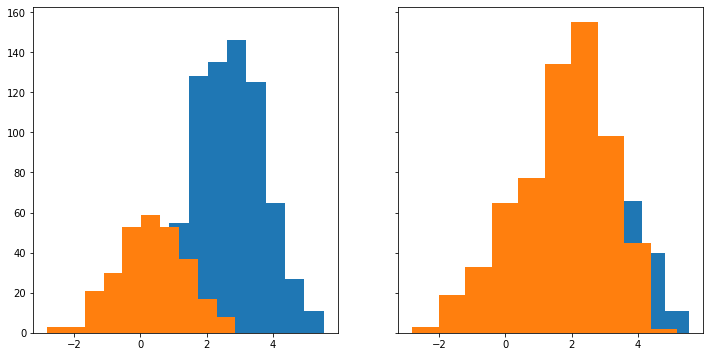

In [35]:
fit = samples.copy()
fit["mean"] = linear_reg_model(x_data).detach().numpy()

S1 = fit[fit["S"] == 1]
S0 = fit[fit["S"] == 0]
R1 = fit[fit["R"] == 1]
R0 = fit[fit["R"] == 0]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
ax[0].hist(R1["mean"])
ax[0].hist(R0["mean"])
ax[1].hist(S1["mean"])
ax[1].hist(S0["mean"])

## Inferring K

This model infers K and uses that to predict FYA instead of relying on R,S (which are parents of G,L making those indirectly biased). First trains on all features (including R and S). Then learns K and uses that to predict F.

In [16]:
samples = pd.DataFrame(columns=['R', 'S', 'A', 'G', 'L', 'F', 'p'])
aware_sample= []
for i in range(1000):
    trace = trace_handler.get_trace()
    R = trace.nodes['R']['value']
    S = trace.nodes['S']['value']
    A = trace.nodes['A']['value']
    G = trace.nodes['G']['value']
    L = trace.nodes['L']['value']
    F = trace.nodes['F']['value']
    # get prob of each combination
    log_prob = trace.log_prob_sum()
    p = np.exp(log_prob)
    samples = samples.append({'R': R, 'S': S, 'A': A, 'G': G, 'L':L, 'F': F, 'p': p}, ignore_index=True)
    aware_sample.append(([R,S,F]))

samples.head()

,R,S,A,G,L,F,p
0,tensor(1.),tensor(0.),tensor(-0.0342),tensor(1.9971),tensor(5.8420),tensor(2.2940),tensor(0.5667)
1,tensor(1.),tensor(0.),tensor(0.5362),tensor(3.4626),tensor(6.2691),tensor(2.8632),tensor(0.1350)
2,tensor(0.),tensor(1.),tensor(0.0234),tensor(3.4050),tensor(0.8411),tensor(0.8340),tensor(0.0717)
3,tensor(1.),tensor(0.),tensor(1.6624),tensor(4.5280),tensor(7.4667),tensor(3.5183),tensor(0.0200)
4,tensor(1.),tensor(1.),tensor(1.0750),tensor(6.7196),tensor(7.6605),tensor(4.3718),tensor(0.1429)


In [41]:
# assign the observed G and L
G=samples.G
L=samples.L

Iterate through all the generated samples and use the G/L (observed variables) to infer that sample's K.

In [98]:
# hold all K values
K=[]
# iterate through the 1000 samples of G/L and infer K
for i in range(1000):
        conditioned = pyro.condition(model, data={"G": G[i], "L": L[i]})

        # use pyro.infer.Importance
        posterior = pyro.infer.Importance(conditioned, num_samples=100).run()
        post_marginal = pyro.infer.EmpiricalMarginal(posterior, "A")
        post_samples = [post_marginal().item() for _ in range(100)]
        post_unique, post_counts = np.unique(post_samples, return_counts=True)
        # calculate the mean of the inferred
        mean = np.mean(post_samples)
        K.append(mean)

Distribution of the Inferred K and the generated K samples 

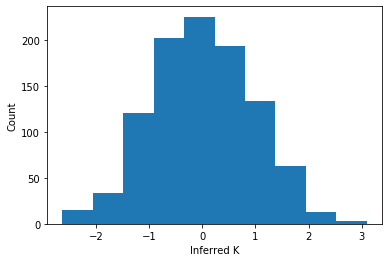

In [108]:
plt.hist(K)
plt.ylabel("Count")
plt.xlabel("Inferred K")
plt.show()

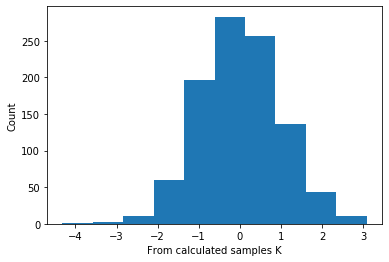

In [107]:
plt.hist([float(a) for a in samples.A])
plt.ylabel("Count")
plt.xlabel("From calculated samples K")
plt.show()

Comparison between some of the rows: 

You can see how closely the inferred K's managed to be to the "actual" K's (which we technically can never know).

In [110]:
for i in range(5, 15, 3):
    print(samples.G[i], samples.L[i], samples.A[i], K[i])

tensor(4.1725) tensor(2.0282) tensor(1.2714) 1.1047669649124146
tensor(0.6776) tensor(4.7277) tensor(-1.0685) -1.0126692789793015
tensor(1.1278) tensor(4.6387) tensor(-1.1928) -1.1516192603111266
tensor(2.0109) tensor(5.6828) tensor(-0.1505) -0.14025823023170234


## Now use our new inferred K into the Linear Reg Model to predict F

In [156]:
#Data to regress
# convert numpy.float64 types to float, then to tensor
x_data, y_data = torch.tensor(np.array(K).tolist()), torch.tensor(samples.F)

# Regression model
linear_reg_model = PyroModule[nn.Linear](1, 1)

# Define loss and optimize
loss_fn = torch.nn.MSELoss(reduction='sum')
optim = torch.optim.Adam(linear_reg_model.parameters(), lr=0.05)
num_iterations = 500 

def train():
    # run the model forward on the data
    y_pred = linear_reg_model(x_data).squeeze(-1)
    # calculate the mse loss
    loss = loss_fn(y_pred, y_data)
    # initialize gradients to zero
    optim.zero_grad()
    # backpropagate
    loss.backward()
    # take a gradient step
    optim.step()
    return loss

for j in range(num_iterations):
    loss = train()
    if (j + 1) % 10 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss.item()))

# Inspect learned parameters
print("Learned parameters:")
for name, param in linear_reg_model.named_parameters():
    print(name, param.data.numpy())

RuntimeError: size mismatch, m1: [1 x 1000], m2: [1 x 1] at ..\aten\src\TH/generic/THTensorMath.cpp:41

(array([461.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 193.]),
 array([0.4549464 , 0.45644417, 0.45794195, 0.45943975, 0.46093753,
        0.4624353 , 0.46393308, 0.46543086, 0.46692866, 0.46842644,
        0.4699242 ], dtype=float32),
 <a list of 10 Patch objects>)

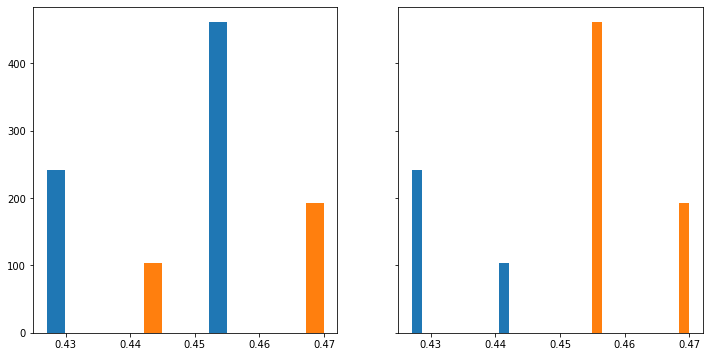

In [85]:
fit = samples.copy()
fit["mean"] = linear_reg_model(A_pred).detach().numpy()

S1 = fit[fit["S"] == 1]
S0 = fit[fit["S"] == 0]
R1 = fit[fit["R"] == 1]
R0 = fit[fit["R"] == 0]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
ax[0].hist(R1["mean"])
ax[0].hist(R0["mean"])
ax[1].hist(S1["mean"])
ax[1].hist(S0["mean"])